<a href="https://colab.research.google.com/github/Voland24/ModernComputerVisionPytorch/blob/main/Chapter_5_Transfer_learning_for_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning

We know the model's performance increases with the number of images we have for training the model. However, it's not always possible to have the option of having thousands of labeled images, sometimes because there aren't enough images, sometimes because it's not possible to label them all with the ground truth labels. This is where transfer learning helps.

The idea here is to take the "learning" the model has done on some generic dataset with millions of examples and apply that to our case, finetuning the model to meet our demands.

Here, we will take a look at various iterations of two different architectures, VGG and ResNet.

We will understand the architectures, apply them to age and gender classification, learn to optimize over both cross entropy and mean absolute error losses at the same time, we will learn how to make the network output 136 values instead of just one and look at the library that can help us reduce code complexity.

Both the VGG and ResNet have been trained on the ImageNet dataset.

**Transfer learning use case scenario**

If we want to classify objects found on the images of streets, such as cars, trees etc. we would have a difficult time training a model from scratch since it's highly unlikely that we could account for all the variations the real world images could have in terms of objects, angles etc. It is much easier and better to use a pretrained model, that has seen countless images of our objects of interes, as well as other obejcts and use it to produce and emmbeding of the images and then just simply train a classificator to classify these images.

**Flow of transfer learning**

1. Normalize the input images with the same mean and stand dev as the images of the pretrained model
2. Fetch the pretrained model's weights and architecture
3. Discard the fully connected layer of the pretrained model
4. Connect our fully connected layer to the network and make sure it has enough output neurons as the classes we want to classify
5. Ensure the weights of the pretrained model are frozen since we don't want to train it any further
6. Update the weight of our layers over epochs




# VGG16 Architecture

VGG stands for Visual Geometry Group and 16 is the number of layers

In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
!pip install torch_summary
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Load the VGG16 model and register it to the device

In [2]:
model = models.vgg16(pretrained = True).to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Let's look at the model's architecture

In [3]:
summary(model, torch.zeros(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

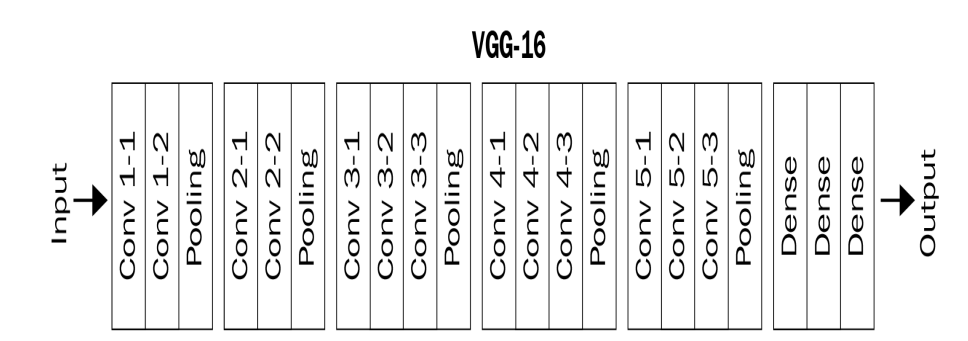

There are ~138 million parameters, of which ~122 million are at the end of the network, in the classification part. There are 13 convolutional layers and 3 linear layers.

In [4]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

There are three major sub modules in the model, the features, the avgpool and the clasiffier. The features and the avgpool modules would be frozen while we delete the classifier module. We delete it and then attach our classifier we wish to train with the desired number of outputs instead of 1000 for our classes we want to predict.


We will now use VGG16 network to classify images of dogs and cats, while training on a datasets that has only 500 images per class, 1000 images in total for class dog and for class cat.

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
import cv2, glob, numpy as np, pandas as pd
from glob import glob
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset

In [6]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [7]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [8]:
train_data_dir = 'training_set/training_set'
test_data_dir = 'test_set/test_set'

After we have downloaded the dataset, now we define a class that will be used to fetch the first 500 images of each folder.
It is also mandatory that we resize, permute and normalize images as to fit the pretrained model. The images are first scaled to 0 to 1 values across all three channels and then normalized to a mean of [0.485,0.456,0.406] and standard deviation of [0/229.0/224.0/225] across all three channels as well.

In [9]:
class CatsDogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder + '/cats/*.jpg')
    dogs = glob(folder + '/dogs/*.jpg')
    self.fpaths = cats[:500] + dogs[:500] #only 500 images per folder cats and dogs
    self.normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    from random import shuffle, seed; seed(10);
    shuffle(self.fpaths) #randomize the order
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] #if the file has 'dog' in the name, class is 1, else 0
  def __len__(self): return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    im = torch.tensor(im/255)
    im = im.permute(2,0,1) #the channels go first, and then height and width
    im = self.normalize(im) # defined in the constructor, normalize is to fit the pretrained model
    return im.float().to(device), torch.tensor([target]).float().to(device)


Let's fetch the images and the coresponding labels

tensor([0.], device='cuda:0')


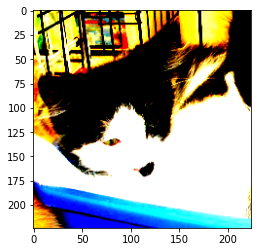

In [10]:
data = CatsDogs(train_data_dir)
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

Define the model

In [11]:
def get_model():
  model = models.vgg16(pretrained = True)
  for param in model.parameters():
    param.requires_grad = False #freeze the params so as not to train them further
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  model.classifier = nn.Sequential( nn.Flatten(),
                                    nn.Linear(512,128),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(128,1),
                                    nn.Sigmoid())
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
  return model.to(device), loss_fn, optimizer

We freeze the grad calculation for the model's params that have been pretrained.
avgpool is the same as max pool but it calculates the average value of the values the kernel covers. Adaptive avg pool is the type of kernel that changes in size depending on the input size. We fix the output size of the layer and thus we can accept any size of the image because we can calculate the needed kernel size.

For the classifier we flatten the output of the avgpool layerm connect the output of 512 neurons to 128 neurons and perform the rest as usual.

We are using the Adam optimizer here.

In [12]:
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Out of ~14 million params we have only ~66k that are trainable here. This is the core of transfer learning, since we are only learning the params of the layers we have added into the pretrained model.

Functions for accuracy, training and getting data

In [13]:
def train_batch(x, y, model, optimizer, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  prediction = model(x)
  is_correct = (prediction >= 0.5) == y
  return is_correct.cpu().numpy().tolist()

def get_data():
  train = CatsDogs(train_data_dir)
  trn_dl = DataLoader(train, batch_size = 32, shuffle = True, drop_last = True)
  val = CatsDogs(test_data_dir)
  val_dl = DataLoader(val, batch_size = 32, shuffle = True, drop_last = True)
  return trn_dl, val_dl


Fetch the model and the data

In [14]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

Let's now train the model

In [15]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
  print(f'Epoch number {epoch + 1}/5')
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies = []

  for ix, batch in enumerate(iter(trn_dl)):
    x,y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()

  for ix, batch in enumerate(iter(trn_dl)):
    x,y = batch
    is_correct = accuracy(x,y,model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x,y = batch
    val_is_correct = accuracy(x,y,model)
    val_epoch_accuracies.extend(val_is_correct)
  val_epoch_accuracy = np.mean(val_epoch_accuracies)

  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)


Epoch number 1/5
Epoch number 2/5
Epoch number 3/5
Epoch number 4/5
Epoch number 5/5


Let's see the performance

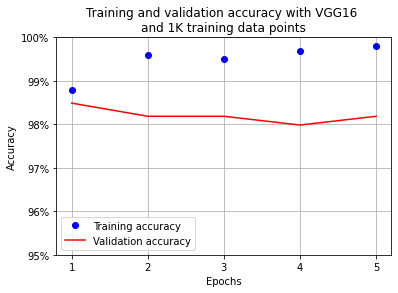

In [16]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', 
 label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', 
 label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
with VGG16 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
 for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()


The accuracy on the validation dataset we get is greater than 98 percent, and is better on the first epoch than the last. So we could stop training there, early stopping is a valid way of keeping the best performing model.

So why don't we just keep adding more and more layers to make deeper networks if they perform better while keeping an eye out for overfitting?

*   Computationally expensive, we have much much more features to learn
*   vanishing gradient arises
*   we modify the images too much in the deeper layers

These problems are solved with the next architecture we are looking at, called ResNet.





# ResNet architecture